In [1]:
# Import könyvtárak
import json
import os
import glob
import re
import shutil
import zipfile
from pathlib import Path
from typing import List, Union
from collections import Counter
from urllib.request import urlretrieve, Request, urlopen
import tempfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def load_json_data(file_path: str):
    """Load data from a single JSON file and return its parsed content."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: JSON file not found at {file_path}")
        raise
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        raise

In [3]:
def download_and_extract_data(data_dir: str, download_url: str) -> bool:
    """
    Download ZIP file from SharePoint and extract JSON files to data_dir.
    Returns True if successful, False otherwise.
    """
    try:
        print(f"Downloading data from SharePoint...")
        
        # Create temporary directory for download
        with tempfile.TemporaryDirectory() as temp_dir:
            zip_path = os.path.join(temp_dir, 'data.zip')
            
            # Download file with custom headers for SharePoint
            print(f"Downloading... (this may take a moment)")
            
            # Create request with headers
            req = Request(download_url)
            req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36')
            req.add_header('Referer', 'https://bmeedu-my.sharepoint.com/')
            req.add_header('Accept', '*/*')
            
            # Download with progress
            with urlopen(req, timeout=60) as response:
                content_type = response.headers.get('Content-Type', '')
                data = response.read()
                
                # Check if it's actually a ZIP file (starts with PK magic number)
                if not data.startswith(b'PK'):
                    print(f"   ✗ Non-ZIP content (Content-Type: {content_type}, Size: {len(data)} bytes)")
                    return False
                
                with open(zip_path, 'wb') as out_file:
                    out_file.write(data)
            
            print(f"✓ Download complete: {os.path.getsize(zip_path)} bytes")
            
            # Extract ZIP
            print(f"Extracting ZIP file...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(temp_dir)
            print(f"✓ Extraction complete")
            
            # Find and copy all JSON files from subdirectories
            json_count = 0
            for root, dirs, files in os.walk(temp_dir):
                for file in files:
                    if file.endswith('.json'):
                        src_path = os.path.join(root, file)
                        dst_path = os.path.join(data_dir, file)
                        shutil.copy2(src_path, dst_path)
                        json_count += 1
            
            print(f"✓ Copied {json_count} JSON files to {data_dir}")
            return json_count > 0
            
    except Exception as e:
        print(f"✗ Error downloading/extracting data: {e}")
        import traceback
        traceback.print_exc()
        return False

In [4]:
def ensure_data_available(data_dir: str) -> bool:
    """
    Check if data_dir has JSON files. If empty, download from SharePoint.
    Returns True if data is available, False otherwise.
    """
    # Create data directory if it doesn't exist
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    
    # Check if any JSON files exist
    json_files = glob.glob(os.path.join(data_dir, '*.json'))
    
    if json_files:
        print(f"✓ Data directory contains {len(json_files)} JSON files")
        return True
    
    print(f"⚠ Data directory is empty or has no JSON files")
    print(f"Attempting to download data from SharePoint...")
    
    # Try different SharePoint URL approaches
    urls = [
        "https://bmeedu-my.sharepoint.com/personal/gyires-toth_balint_vik_bme_hu/_layouts/15/download.aspx?share=IQDYwXUJcB_jQYr0bDfNT5RKARYgfKoH97zho3rxZ46KA1I",
        "https://bmeedu-my.sharepoint.com/:u:/g/personal/gyires-toth_balint_vik_bme_hu/IQDYwXUJcB_jQYr0bDfNT5RKARYgfKoH97zho3rxZ46KA1I?e=iFp3iz&download=1",
    ]
    
    for url in urls:
        success = download_and_extract_data(data_dir, url)
        if success:
            print(f"✓ Data downloaded and extracted successfully")
            return True
    
    # All attempts failed
    print(f"✗ Failed to download data. Please provide data files in {data_dir}")
    return False

In [5]:
def load_json_items(input_path: str) -> List[Union[dict, list]]:
    """Load items from a JSON file or from all JSON files in a directory.

    - If input_path is a directory: loads all *.json files and concatenates lists.
    - If input_path is a file: loads that JSON.
    Returns a list of items (dicts) with source file annotated.
    """
    if os.path.isdir(input_path):
        print(f"Loading all JSON files from directory: {input_path}")
        items: List[dict] = []
        json_files = sorted(glob.glob(os.path.join(input_path, '*.json')))
        if not json_files:
            raise FileNotFoundError(f"No JSON files found in directory: {input_path}")
        for fp in json_files:
            data = load_json_data(fp)
            if isinstance(data, list):
                for it in data:
                    if isinstance(it, dict):
                        it = {**it, "__source_file__": os.path.basename(fp)}
                        items.append(it)
            elif isinstance(data, dict):
                data["__source_file__"] = os.path.basename(fp)
                items.append(data)
            else:
                print(f"Warning: Unsupported JSON root type in {fp}: {type(data)} — skipping")
        print(f"Total items loaded from directory: {len(items)}")
        return items
    elif os.path.isfile(input_path):
        print(f"Loading JSON data from file: {input_path}")
        data = load_json_data(input_path)
        if isinstance(data, list):
            items = []
            for it in data:
                if isinstance(it, dict):
                    it = {**it, "__source_file__": os.path.basename(input_path)}
                    items.append(it)
            return items
        elif isinstance(data, dict):
            data["__source_file__"] = os.path.basename(input_path)
            return [data]
        else:
            raise ValueError(f"Unsupported JSON root type in {input_path}: {type(data)}")
    else:
        raise FileNotFoundError(f"Input path does not exist: {input_path}")

In [6]:
# Konfigurációs változók
STEP_PREFIX = '01-acquisition'

def save_histogram(series: pd.Series, title: str, path: str, bins: int = 50):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(series.values, bins=bins)
    ax.set_title(title)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    fig.tight_layout()
    fig.savefig(path)
    plt.close(fig)
    print(f"Grafikon mentve: {path}")

In [7]:
# READABILITY METRICS

def count_syllables_hu(word: str) -> int:
    """Approximate syllable count for Hungarian words based on vowels."""
    vowels = 'aáeéiíoóöőuúüű'
    word = word.lower()
    syllable_count = 0
    previous_was_vowel = False
    for char in word:
        is_vowel = char in vowels
        if is_vowel and not previous_was_vowel:
            syllable_count += 1
        previous_was_vowel = is_vowel
    return max(1, syllable_count)


def flesch_reading_ease_hu(text: str) -> float:
    """Flesch Reading Ease adapted for Hungarian.
    Higher score = easier to read (0-100 scale).
    """
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    if not sentences:
        return 0.0
    
    words = text.split()
    if not words:
        return 0.0
    
    total_syllables = sum(count_syllables_hu(w) for w in words)
    avg_sentence_length = len(words) / len(sentences)
    avg_syllables_per_word = total_syllables / len(words)
    
    score = 206.835 - 1.015 * avg_sentence_length - 84.6 * avg_syllables_per_word
    return max(0.0, min(100.0, score))


def gunning_fog_index(text: str) -> float:
    """Gunning Fog Index: years of education needed to understand text."""
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    if not sentences:
        return 0.0
    
    words = text.split()
    if not words:
        return 0.0
    
    complex_words = sum(1 for w in words if count_syllables_hu(w) >= 3)
    avg_sentence_length = len(words) / len(sentences)
    percent_complex = (complex_words / len(words)) * 100
    
    fog = 0.4 * (avg_sentence_length + percent_complex)
    return fog


def smog_index(text: str) -> float:
    """SMOG Index: years of education needed."""
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 3:
        return 0.0
    
    words = text.split()
    if not words:
        return 0.0
    
    complex_words = sum(1 for w in words if count_syllables_hu(w) >= 3)
    smog = 1.0430 * np.sqrt(complex_words * (30 / len(sentences))) + 3.1291
    return smog

In [8]:
# LEXICAL DIVERSITY METRICS

def type_token_ratio(text: str) -> float:
    """TTR: unique words / total words."""
    words = text.lower().split()
    if not words:
        return 0.0
    return len(set(words)) / len(words)


def moving_average_ttr(text: str, window_size: int = 100) -> float:
    """MATTR: average TTR over moving windows."""
    words = text.lower().split()
    if len(words) < window_size:
        return type_token_ratio(text)
    
    ttrs = []
    for i in range(len(words) - window_size + 1):
        window = words[i:i+window_size]
        ttrs.append(len(set(window)) / len(window))
    
    return np.mean(ttrs) if ttrs else 0.0


def hapax_legomena_ratio(text: str) -> float:
    """Ratio of words that appear only once."""
    words = text.lower().split()
    if not words:
        return 0.0
    word_counts = Counter(words)
    hapax = sum(1 for count in word_counts.values() if count == 1)
    return hapax / len(words)

In [9]:
def compute_readability_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Add readability metrics to dataframe."""
    df = df.copy()
    texts = df['text_raw'].astype(str)
    
    print("Computing readability metrics...")
    df['flesch_score'] = texts.apply(flesch_reading_ease_hu)
    df['fog_index'] = texts.apply(gunning_fog_index)
    df['smog_index'] = texts.apply(smog_index)
    
    return df


def compute_lexical_diversity(df: pd.DataFrame) -> pd.DataFrame:
    """Add lexical diversity metrics to dataframe."""
    df = df.copy()
    texts = df['text_raw'].astype(str)
    
    print("Computing lexical diversity metrics...")
    df['ttr'] = texts.apply(type_token_ratio)
    df['mattr'] = texts.apply(moving_average_ttr)
    df['hapax_ratio'] = texts.apply(hapax_legomena_ratio)
    
    return df

In [10]:
def plot_metrics_by_label(df: pd.DataFrame, features_dir: str):
    """Plot readability and lexical metrics grouped by label."""
    if 'label_raw' not in df.columns:
        print("Skipping label-based plots: no label_raw column")
        return
    
    metrics = ['flesch_score', 'fog_index', 'smog_index', 'ttr', 'mattr', 'hapax_ratio']
    available_metrics = [m for m in metrics if m in df.columns]
    
    if not available_metrics:
        return
    
    for metric in available_metrics:
        fig, ax = plt.subplots(figsize=(10, 6))
        df_plot = df[df[metric].notna()].copy()
        df_plot = df_plot[df_plot['label_raw'].notna()].copy()
        labels_sorted = sorted([l for l in df_plot['label_raw'].unique() if l is not None])
        
        if not labels_sorted:
            plt.close(fig)
            continue
        
        data_to_plot = [df_plot[df_plot['label_raw'] == label][metric].values 
                        for label in labels_sorted]
        
        ax.boxplot(data_to_plot, tick_labels=labels_sorted, patch_artist=True)
        ax.set_title(f'{metric.replace("_", " ").title()} by Label')
        ax.set_xlabel('Label')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.grid(axis='y', alpha=0.3)
        fig.tight_layout()
        
        out_path = os.path.join(features_dir, f'{STEP_PREFIX}_{metric}_by_label.png')
        fig.savefig(out_path)
        plt.show()
        plt.close(fig)
        print(f"Saved {metric} by label plot -> {out_path}")

In [11]:
def compute_tfidf_top_words(df: pd.DataFrame, features_dir: str, top_n: int = 20):
    """Compute and save top TF-IDF words per label."""
    if 'label_raw' not in df.columns:
        print("Skipping TF-IDF: no label_raw column")
        return
    
    print("Computing TF-IDF top words per label...")
    
    labels = [l for l in df['label_raw'].unique() if l is not None]
    results = []
    
    for label in sorted(labels):
        label_texts = df[df['label_raw'] == label]['text_raw'].astype(str).tolist()
        if not label_texts:
            continue
        
        vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2), 
                                     min_df=2, max_df=0.8)
        try:
            tfidf_matrix = vectorizer.fit_transform(label_texts)
            feature_names = vectorizer.get_feature_names_out()
            
            avg_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
            top_indices = avg_scores.argsort()[-top_n:][::-1]
            
            top_words = [(feature_names[i], avg_scores[i]) for i in top_indices]
            results.append({
                'label': label,
                'top_words': ', '.join([f"{word}({score:.3f})" for word, score in top_words[:10]])
            })
        except Exception as e:
            print(f"TF-IDF failed for label {label}: {e}")
    
    if results:
        df_tfidf = pd.DataFrame(results)
        out_csv = os.path.join(features_dir, f'{STEP_PREFIX}_tfidf_top_words_by_label.csv')
        df_tfidf.to_csv(out_csv, index=False, encoding='utf-8-sig')
        print(f"Saved TF-IDF results -> {out_csv}")
        display(df_tfidf)

In [12]:
def plot_correlation_matrix(df: pd.DataFrame, features_dir: str):
    """Plot correlation heatmap of numerical features including label."""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'label_raw' in df.columns:
        df_corr = df.copy()
        df_corr['label_numeric'] = df_corr['label_raw'].astype(str).str.extract(r'(\d+)')[0].astype(float)
        numeric_cols.append('label_numeric')
    else:
        df_corr = df.copy()
    
    relevant = [col for col in numeric_cols if col in df_corr.columns]
    if len(relevant) < 2:
        print("Not enough numeric columns for correlation matrix")
        return
    
    corr_matrix = df_corr[relevant].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
               center=0, ax=ax, square=True, linewidths=0.5)
    
    ax.set_title('Feature Correlation Matrix')
    fig.tight_layout()
    
    out_path = os.path.join(features_dir, f'{STEP_PREFIX}_correlation_matrix.png')
    fig.savefig(out_path, dpi=100)
    plt.show()
    plt.close(fig)
    print(f"Saved correlation matrix -> {out_path}")

In [13]:
def plot_top_confusion_pairs(df: pd.DataFrame, features_dir: str):
    """Plot top confusion pairs: szomszédos címkék közötti potenciális összekeverés."""
    if 'label_raw' not in df.columns:
        print("Skipping confusion pairs: no label_raw column")
        return
    
    df_analysis = df.copy()
    df_analysis['label_numeric'] = df_analysis['label_raw'].astype(str).str.extract(r'(\d+)')[0].astype(float)
    
    label_pairs = []
    for label_num in sorted(df_analysis['label_numeric'].dropna().unique()):
        neighbor = label_num + 1
        if neighbor in df_analysis['label_numeric'].values:
            label_1 = df_analysis[df_analysis['label_numeric'] == label_num]['label_raw'].iloc[0]
            label_2 = df_analysis[df_analysis['label_numeric'] == neighbor]['label_raw'].iloc[0]
            count_1 = len(df_analysis[df_analysis['label_numeric'] == label_num])
            count_2 = len(df_analysis[df_analysis['label_numeric'] == neighbor])
            avg_count = (count_1 + count_2) / 2
            label_pairs.append((f"{label_1} ↔ {label_2}", avg_count))
    
    if not label_pairs:
        print("No confusion pairs to plot")
        return
    
    label_pairs = sorted(label_pairs, key=lambda x: x[1], reverse=True)[:5]
    pair_names, pair_counts = zip(*label_pairs)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(pair_names, pair_counts, color='#F58518')
    ax.set_xlabel('Átlagos mintaszám (potenciális összekeverés)')
    ax.set_title('Top Confusion Pairs (szomszédos címkék)')
    fig.tight_layout()
    
    out_path = os.path.join(features_dir, f'{STEP_PREFIX}_top_confusion_pairs.png')
    fig.savefig(out_path)
    plt.show()
    plt.close(fig)
    print(f"Saved top confusion pairs -> {out_path}")

In [14]:
def raw_eda(df: pd.DataFrame, features_dir: str):
    """Compute and save simple EDA plots on RAW text (no cleaning)."""
    texts = df.get('text_raw', pd.Series([], dtype=str)).astype(str)
    word_counts = texts.apply(lambda t: len(t.split()))
    avg_word_len = texts.apply(lambda t: np.mean([len(w) for w in t.split()]) if t.split() else 0.0)

    Path(features_dir).mkdir(parents=True, exist_ok=True)
    save_histogram(word_counts, 'RAW Word Count Distribution', 
                   os.path.join(features_dir, f'{STEP_PREFIX}_raw_word_count_hist.png'))
    save_histogram(avg_word_len, 'RAW Average Word Length Distribution', 
                   os.path.join(features_dir, f'{STEP_PREFIX}_raw_avg_word_len_hist.png'))

In [15]:
def extract_label_from_annotations(annotations_raw: str):
    """Extract label from Label Studio annotations JSON."""
    if not annotations_raw:
        return None
    try:
        annotations = json.loads(annotations_raw)
        if annotations and isinstance(annotations, list) and len(annotations) > 0:
            return annotations[0]['result'][0]['value']['choices'][0]
    except (KeyError, IndexError, TypeError, json.JSONDecodeError):
        return None
    return None

In [16]:
def eda_label_analysis(df: pd.DataFrame, raw_dir: str, features_dir: str):
    """Perform EDA-only label checks."""
    if 'text_raw' not in df.columns:
        print("EDA label analysis skipped: 'text_raw' column missing.")
        return

    df = df.copy()
    df['label_raw'] = df.get('annotations_raw', '').apply(extract_label_from_annotations)

    total_rows = len(df)
    missing_mask = (df['label_raw'].isna() | (df['label_raw'] == '')) | (df['text_raw'].isna() | (df['text_raw'] == ''))
    missing_count = int(missing_mask.sum())

    print(f"EDA label analysis: rows={total_rows}, missing_label_or_text={missing_count}")

    # Save statistics
    stats_file = os.path.join(features_dir, f'{STEP_PREFIX}_raw_eda_statistics.txt')
    with open(stats_file, 'w', encoding='utf-8') as f:
        f.write("RAW EDA Statisztikák\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Összes sor: {total_rows}\n")
        f.write(f"Hiányzó label VAGY üres text: {missing_count}\n")
    print(f"Saved EDA statistics -> {stats_file}")

    # Plot label distribution
    try:
        counts = df['label_raw'].value_counts().sort_values(ascending=False)
        if len(counts) == 0:
            print("No labels available for distribution plot.")
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            counts.plot(kind='bar', ax=ax, color='#4C78A8')
            ax.set_title('Besorolás eloszlás (RAW EDA)')
            ax.set_xlabel('Besorolás (label)')
            ax.set_ylabel('Darab')
            fig.tight_layout()
            out_fig = os.path.join(features_dir, f'{STEP_PREFIX}_raw_label_distribution.png')
            fig.savefig(out_fig)
            plt.show()
            plt.close(fig)
            print(f"Saved label distribution plot -> {out_fig}")
    except Exception as e:
        print(f"Failed to generate label distribution plot: {e}")

    print("\n" + "="*50)
    print("ADVANCED STATISTICAL ANALYSIS")
    print("="*50)
    
    # Compute metrics
    try:
        df = compute_readability_metrics(df)
        print("✓ Readability metrics computed")
    except Exception as e:
        print(f"✗ Readability metrics failed: {e}")
    
    try:
        df = compute_lexical_diversity(df)
        print("✓ Lexical diversity metrics computed")
    except Exception as e:
        print(f"✗ Lexical diversity failed: {e}")
    
    try:
        plot_metrics_by_label(df, features_dir)
        print("✓ Metrics by label plots saved")
    except Exception as e:
        print(f"✗ Metrics by label plots failed: {e}")
    
    try:
        compute_tfidf_top_words(df, features_dir)
        print("✓ TF-IDF analysis completed")
    except Exception as e:
        print(f"✗ TF-IDF analysis failed: {e}")
    
    try:
        plot_correlation_matrix(df, features_dir)
        print("✓ Correlation matrix saved")
    except Exception as e:
        print(f"✗ Correlation matrix failed: {e}")
    
    try:
        plot_top_confusion_pairs(df, features_dir)
        print("✓ Top confusion pairs plot saved")
    except Exception as e:
        print(f"✗ Top confusion pairs failed: {e}")
    
    # Save enhanced dataset
    try:
        out_csv_enhanced = os.path.join(raw_dir, 'raw_dataset_eda_enhanced.csv')
        df_enhanced = df.drop(columns=['row_id'], errors='ignore')
        df_enhanced.to_csv(out_csv_enhanced, index=False, encoding='utf-8-sig')
        print(f"✓ Saved enhanced EDA dataset -> {out_csv_enhanced}")
    except Exception as e:
        print(f"✗ Failed to save enhanced dataset: {e}")
    
    print("="*50)
    print("ADVANCED ANALYSIS COMPLETE")
    print("="*50 + "\n")
    
    return df

In [17]:
def process_raw_data(input_path: str, raw_dir: str, features_dir: str):
    """Aggregate RAW JSON items and persist a lightweight snapshot."""
    Path(raw_dir).mkdir(parents=True, exist_ok=True)
    Path(features_dir).mkdir(parents=True, exist_ok=True)

    print("Loading JSON data...")
    data_items = load_json_items(input_path)

    records = []
    for item in data_items:
        text = ''
        annotations = None
        source = ''
        if isinstance(item, dict):
            text = item.get('data', {}).get('text', '')
            annotations = item.get('annotations')
            source = item.get('__source_file__', '')
        records.append({
            'text_raw': text if text is not None else '',
            'annotations_raw': json.dumps(annotations, ensure_ascii=False) if annotations is not None else '',
            'source_file': source
        })

    df = pd.DataFrame(records)
    print(f"RAW rows aggregated: {len(df)}")

    raw_csv = os.path.join(raw_dir, 'raw_dataset.csv')
    df.to_csv(raw_csv, index=False, encoding='utf-8-sig')
    print(f"Saved RAW dataset -> {raw_csv}")

    # RAW EDA
    try:
        raw_eda(df, features_dir)
        print(f"Saved RAW EDA plots to {features_dir}")
    except Exception as e:
        print(f"RAW EDA failed (continuing): {e}")

    # Additional EDA
    try:
        df = eda_label_analysis(df, raw_dir, features_dir)
    except Exception as e:
        print(f"EDA label analysis failed (continuing): {e}")
    
    return df

## Adatok betöltése és elemzése

Most futtatjuk a pipeline-t:

Input path: /app/data
RAW output: /app/output/raw
✓ Data directory contains 62 JSON files
Loading JSON data...
Loading all JSON files from directory: /app/data
Total items loaded from directory: 6288
RAW rows aggregated: 6288
Saved RAW dataset -> /app/output/raw/raw_dataset.csv
Grafikon mentve: /app/output/reports/01-acquisition_raw_word_count_hist.png
Grafikon mentve: /app/output/reports/01-acquisition_raw_avg_word_len_hist.png
Saved RAW EDA plots to /app/output/reports
EDA label analysis: rows=6288, missing_label_or_text=194
Saved EDA statistics -> /app/output/reports/01-acquisition_raw_eda_statistics.txt


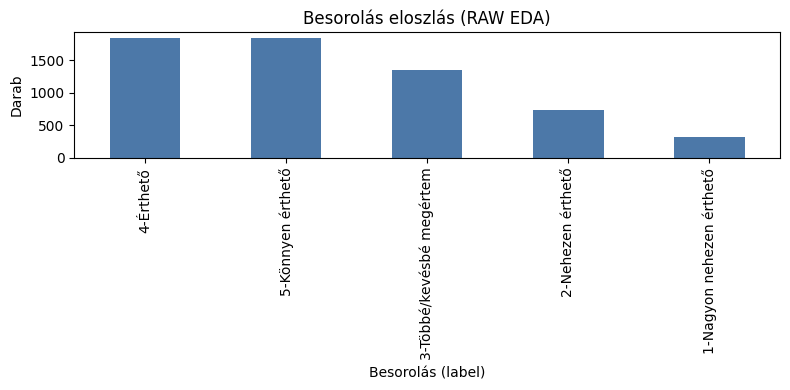

Saved label distribution plot -> /app/output/reports/01-acquisition_raw_label_distribution.png

ADVANCED STATISTICAL ANALYSIS
Computing readability metrics...
✓ Readability metrics computed
Computing lexical diversity metrics...
✓ Lexical diversity metrics computed


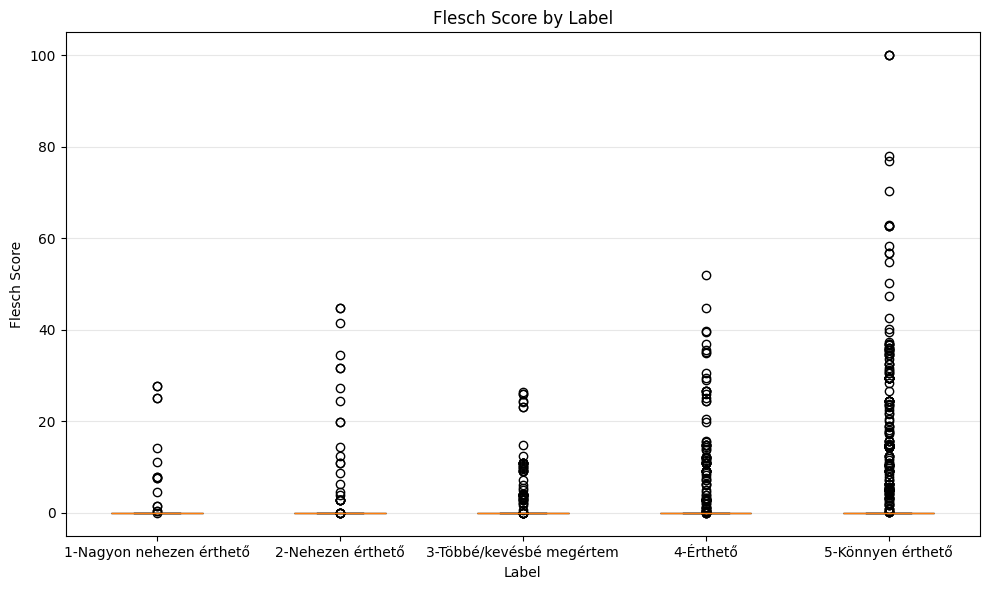

Saved flesch_score by label plot -> /app/output/reports/01-acquisition_flesch_score_by_label.png


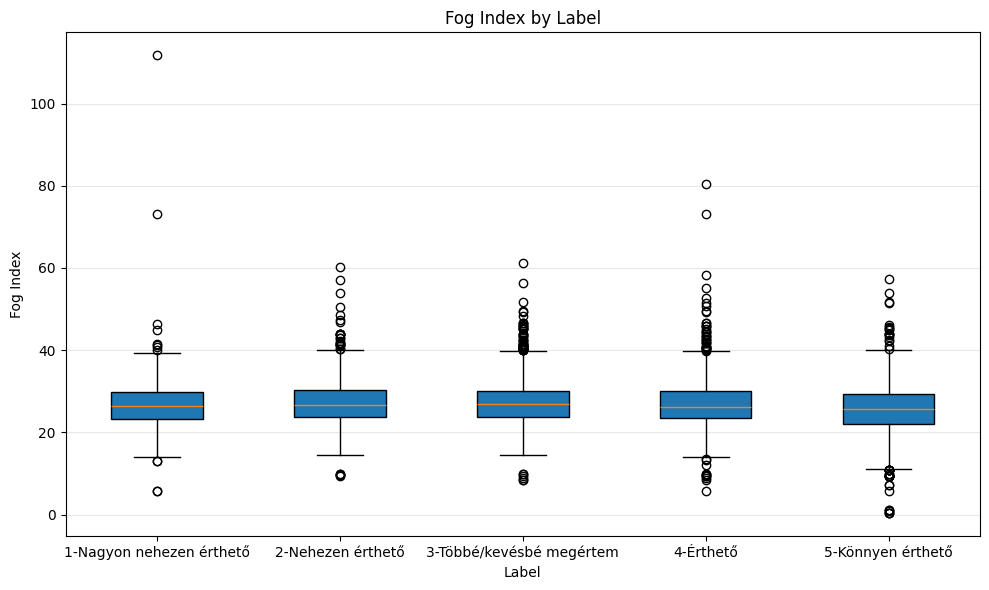

Saved fog_index by label plot -> /app/output/reports/01-acquisition_fog_index_by_label.png


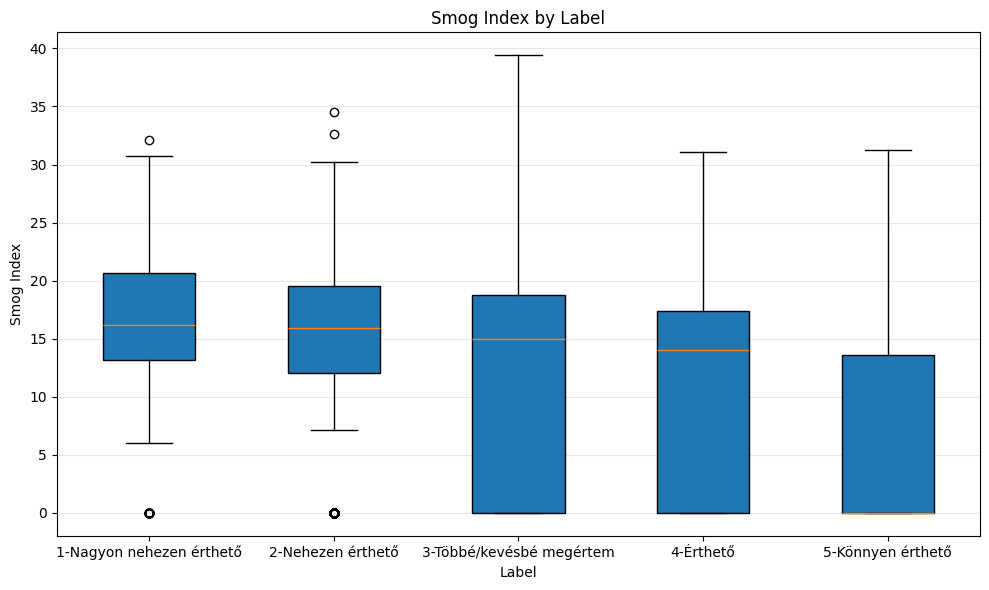

Saved smog_index by label plot -> /app/output/reports/01-acquisition_smog_index_by_label.png


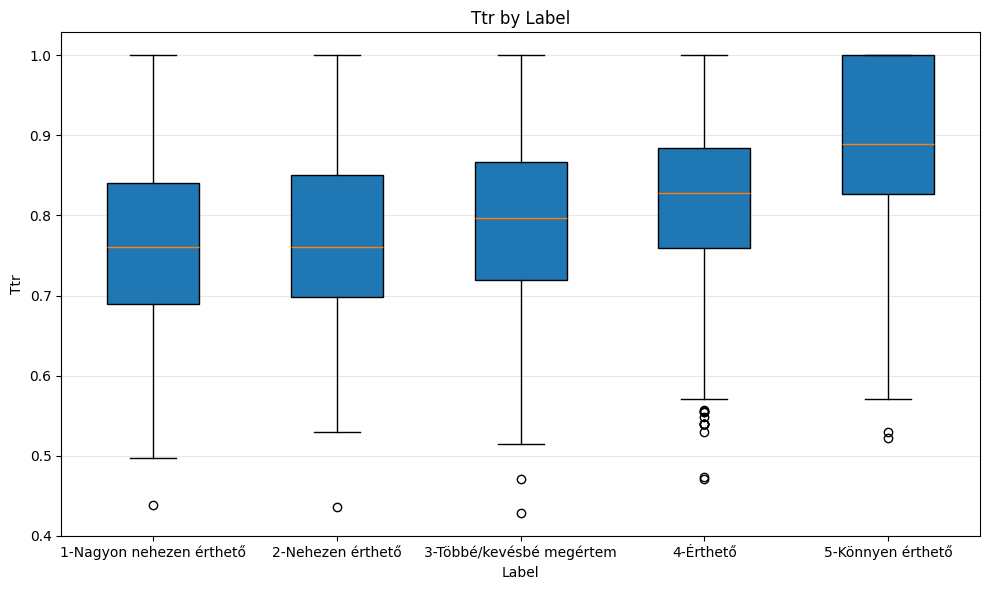

Saved ttr by label plot -> /app/output/reports/01-acquisition_ttr_by_label.png


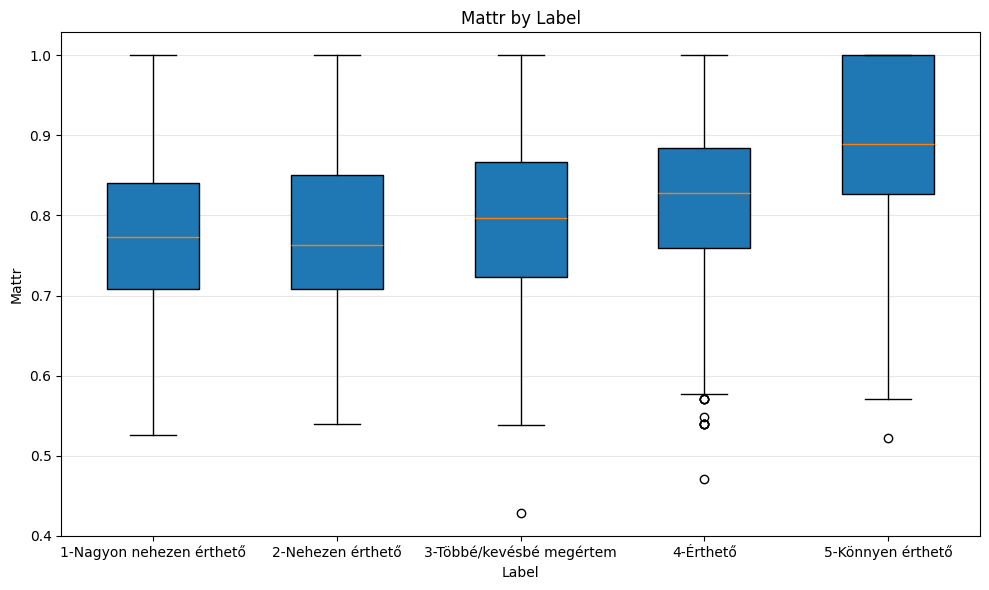

Saved mattr by label plot -> /app/output/reports/01-acquisition_mattr_by_label.png


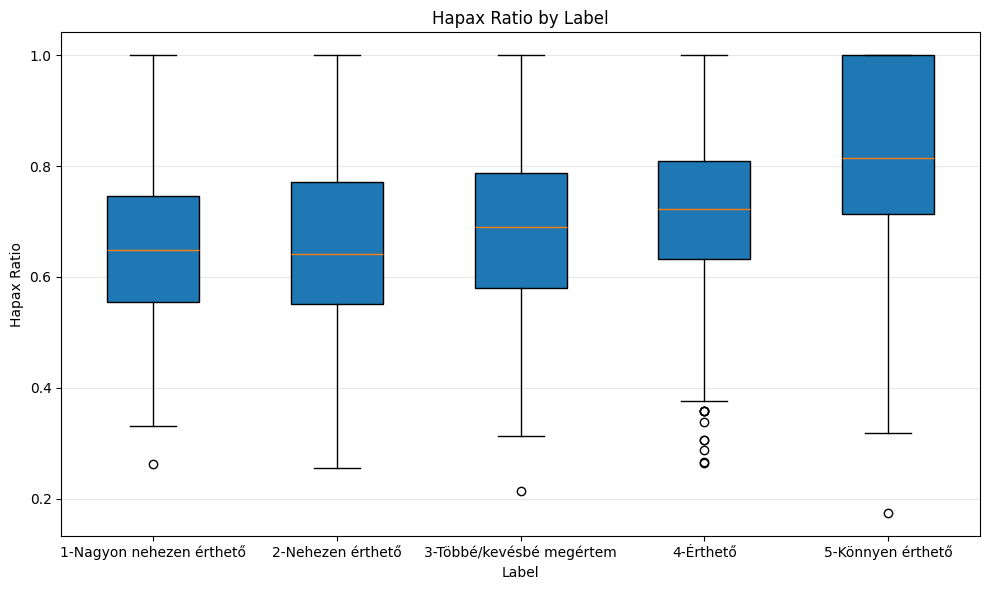

Saved hapax_ratio by label plot -> /app/output/reports/01-acquisition_hapax_ratio_by_label.png
✓ Metrics by label plots saved
Computing TF-IDF top words per label...
Saved TF-IDF results -> /app/output/reports/01-acquisition_tfidf_top_words_by_label.csv


,label,top_words
0,1-Nagyon nehezen érthető,"és(0.083), nem(0.059), vagy(0.054), bank(0.052..."
1,2-Nehezen érthető,"és(0.075), bank(0.064), nem(0.059), vagy(0.059..."
2,3-Többé/kevésbé megértem,"és(0.071), bank(0.063), vagy(0.057), nem(0.056..."
3,4-Érthető,"az(0.122), és(0.070), bank(0.058), vagy(0.053)..."
4,5-Könnyen érthető,"az(0.097), és(0.061), bank(0.042), nem(0.042),..."


✓ TF-IDF analysis completed


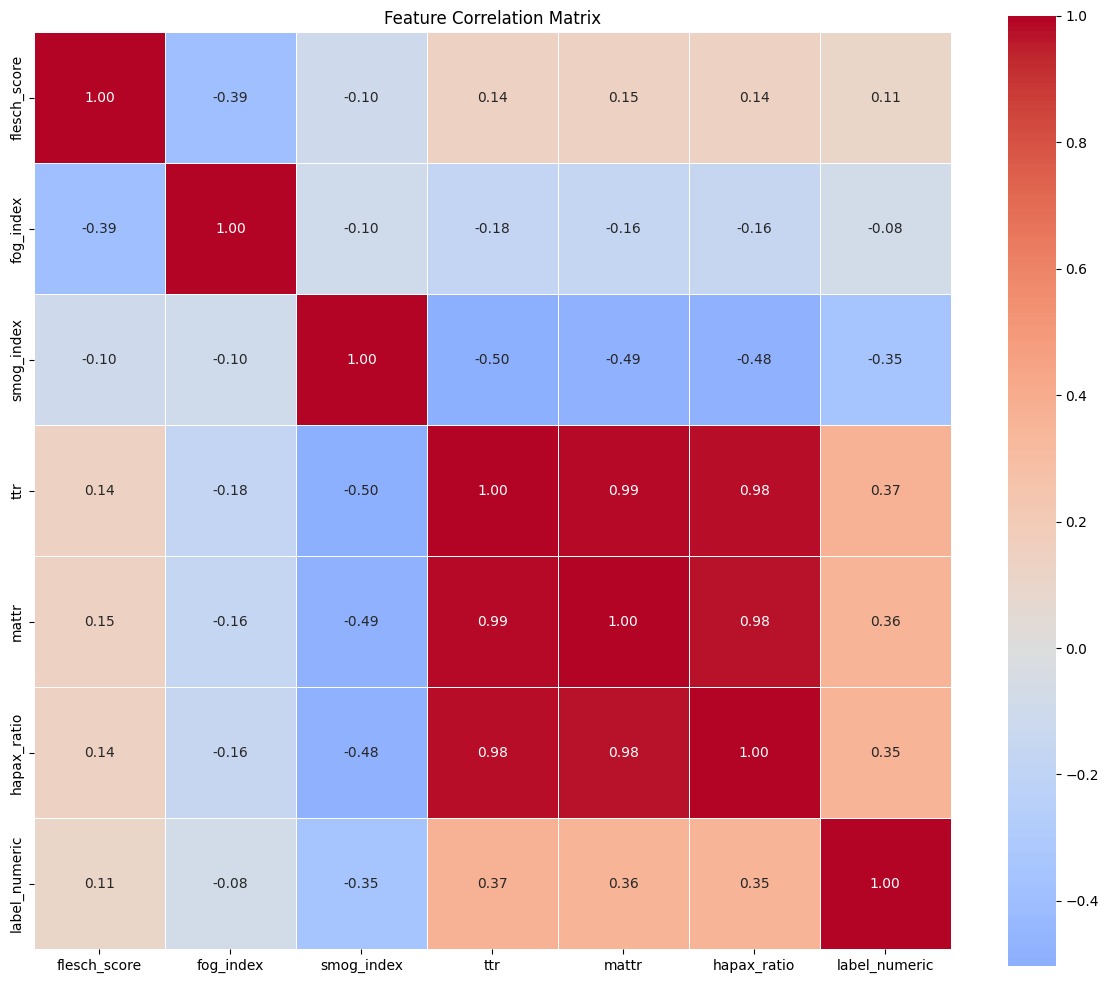

Saved correlation matrix -> /app/output/reports/01-acquisition_correlation_matrix.png
✓ Correlation matrix saved


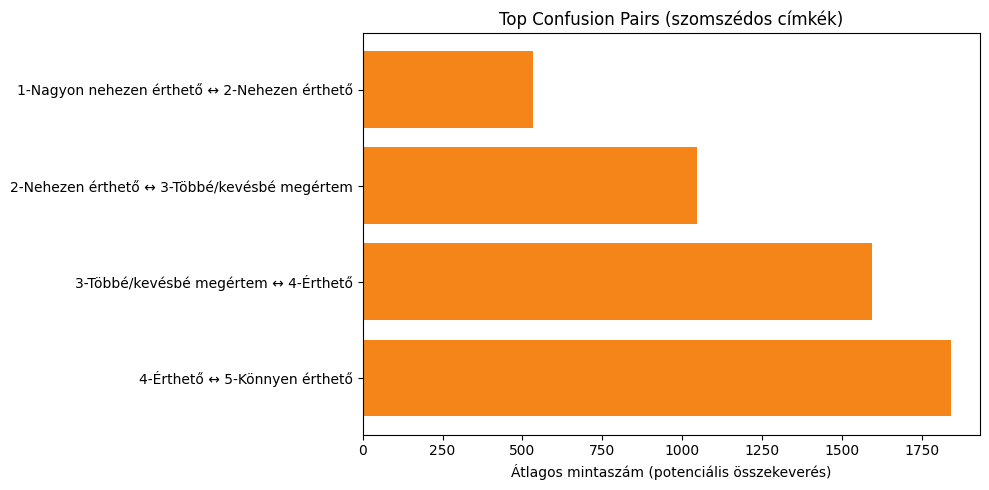

Saved top confusion pairs -> /app/output/reports/01-acquisition_top_confusion_pairs.png
✓ Top confusion pairs plot saved
✓ Saved enhanced EDA dataset -> /app/output/raw/raw_dataset_eda_enhanced.csv
ADVANCED ANALYSIS COMPLETE


Data processing complete!


,text_raw,annotations_raw,source_file,label_raw,flesch_score,fog_index,smog_index,ttr,mattr,hapax_ratio
0,2. Ügyfélnek tekintendő az a természetes szemé...,"[{""id"": 1, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json,3-Többé/kevésbé megértem,0.005196,21.003922,15.470042,0.647059,0.647059,0.455882
1,4. Az OTP Bank Nyrt. az Üzletszabályzatban fog...,"[{""id"": 2, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json,3-Többé/kevésbé megértem,0.000000,23.488172,15.903189,0.903226,0.903226,0.838710
2,6. Amennyiben az OTP Bank Nyrt. valamely szolg...,"[{""id"": 3, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json,4-Érthető,0.000000,22.933333,14.068176,0.909091,0.909091,0.863636
3,1. Az OTP Bank Nyrt. jogosult meggyőződni az Ü...,"[{""id"": 4, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json,5-Könnyen érthető,0.000000,19.066667,12.161745,0.875000,0.875000,0.791667
4,2. Az OTP Bank Nyrt. a pénzmosás és a terroriz...,"[{""id"": 5, ""completed_by"": 1, ""result"": [{""val...",A5VHUA.json,4-Érthető,0.000000,24.751515,14.554593,0.909091,0.909091,0.818182


In [18]:
# Konfigurációs változók
data_dir = os.getenv('DATA_DIR', '../data')
base_output = os.getenv('OUTPUT_DIR', '../output')

raw_dir = os.path.join(base_output, 'raw')
features_dir = os.path.join(base_output, 'reports')

print(f"Input path: {data_dir}")
print(f"RAW output: {raw_dir}")

# Ensure data is available
if not ensure_data_available(data_dir):
    print("ERROR: No data available. Exiting.")
else:
    # Process data
    df_result = process_raw_data(data_dir, raw_dir, features_dir)
    print("\nData processing complete!")
    display(df_result.head())